In [1]:
import numpy as np
import pandas as pd

def parse_coords(coords):
    return [float(x) for x in coords.split('-')]

def get_x(filename):
    x_pd = pd.read_csv(filename, header=None)
    x_pd_parsed = x_pd.applymap(parse_coords)
    x_np = x_pd_parsed.to_numpy()
    return np.array([[x for x in y] for y in x_np[:]])

def get_y(filename):
    x_pd = pd.read_csv(filename, header=None)
    return x_pd.to_numpy()

In [2]:
X = get_x('data/train_x.csv')
y = get_y('data/train_y.csv').reshape((-1))

X_test = get_x('data/test_x.csv')
y_test = get_y('data/test_y.csv').reshape((-1))

In [3]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches




def plot_path(verts, ax):
    ax.axis('off')
    
    xs, ys = zip(*verts)
    ax.plot(xs, ys, 'x--', lw=2, color='black', ms=10)

    i=0
    for x,y in verts:
        rand_x,rand_y = np.random.rand(2)-0.5
        ax.text(x+rand_x, y+rand_y, 'P'+str(i))
        i += 1

    min_x,max_x = np.min(verts[:,0]),np.max(verts[:,0])
    min_y,max_y = np.min(verts[:,1]),np.max(verts[:,1])


    ax.set_xlim(min_x - 1, max_x + 1)
    ax.set_ylim(min_y - 1, max_y + 1)
    
def plot_many(samples, labels=None):
    n = (samples.shape[0])
    if n < 20 :
        cols = 5
        rows = int((n+4)/5)
        fig = plt.figure(figsize=(cols * 4, rows * 4))
    else :
        cols = 8
        rows = int((n+cols-1)/cols)
        fig = plt.figure(figsize=(cols * 3, rows * 3))
    
    for i in range(n):
        sub = fig.add_subplot(rows, cols, i + 1)
        if labels is not None :
            sub.title.set_text('y={0}'.format(labels[i]))
        else :
            sub.title.set_text('nolabel')
        plot_path(samples[i], sub)

n = 10
plot_many(X[:n], y[:n])

In [58]:
import torch.nn as nn
import torch
import torch.nn.functional as F

torch.manual_seed(1)

class Net(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim

#         self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, output_dim)

    def forward(self, sentence):
        hidden = (torch.randn(1, 1, self.hidden_dim), torch.randn(1, 1, self.hidden_dim))
        lstm_out, _ = self.lstm(sentence, hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores[-1]

n_hidden = 128
n_letters = 2
n_categories = 4

model = Net(n_letters, n_hidden, n_categories)

In [59]:
from torchvision.transforms.functional import to_tensor


Xt = to_tensor(X).float().permute(1,2,0)
inp = Xt[0].view(len(Xt[0]), 1, -1)
hidden = (torch.randn(1, 1, n_hidden), torch.randn(1, 1, n_hidden))
print(inp.shape)
output = model(inp)
yt = torch.zeros(y.shape[0],4)
for i,idx in enumerate(y):
    yt[i,idx] = 1
yt[:5]
print(output)

torch.Size([5, 1, 2])
tensor([-1.2465, -1.2498, -1.5059, -1.5890], grad_fn=<SelectBackward>)


In [60]:
import torch.optim as optim

loss_function = nn.NLLLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.004)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    row = Xt[0]
    sentence_in = row.view(len(row), 1, -1)
    tag_scores = model(sentence_in)
    print(tag_scores)

loss_log = []
    

tensor([-1.3009, -1.2563, -1.4999, -1.5148])


In [61]:
optimizer = optim.Adam(model.parameters(), lr=0.003)
for i in range(len(Xt)) :
    # Step 1. Remember that Pytorch accumulates gradients.
    # We need to clear them out before each instance
    model.zero_grad()

    # Step 2. Get our inputs ready for the network, that is, turn them into
    # Tensors of word indices.
    row = Xt[i][:-1]
    sentence_in = row.view(len(row), 1, -1)
    targets = torch.tensor([y[i]], dtype=torch.long)

    # Step 3. Run our forward pass.
    tag_scores = model(sentence_in)
    tag_scores = tag_scores.view(1,-1)

    # Step 4. Compute the loss, gradients, and update the parameters by
    #  calling optimizer.step()
    loss = loss_function(tag_scores, targets)
    acc_loss += loss.item()
    loss.backward()
    optimizer.step()



for epoch in range(40):  # again, normally you would NOT do 300 epochs, it is toy data
    acc_loss = 0
    optimizer = optim.Adam(model.parameters(), lr=0.003)
    for i in range(len(Xt)) :
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        row = Xt[i]
        sentence_in = row.view(len(row), 1, -1)
        targets = torch.tensor([y[i]], dtype=torch.long)
        
        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)
        tag_scores = tag_scores.view(1,-1)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        acc_loss += loss.item()
        loss.backward()
        optimizer.step()
    loss_log.append(acc_loss)
    print("epoch", epoch, "loss", acc_loss)

epoch 0 loss 8394.780756400898
epoch 1 loss 8251.531229866669
epoch 2 loss 8184.489191234112
epoch 3 loss 8143.3194277100265
epoch 4 loss 8090.819266079925
epoch 5 loss 8025.21210849518
epoch 6 loss 8020.309989829548
epoch 7 loss 7984.190435836092
epoch 8 loss 7909.151311963331
epoch 9 loss 7927.1693938476965
epoch 10 loss 7889.809148994042
epoch 11 loss 7815.1109565345105
epoch 12 loss 7856.972178614116
epoch 13 loss 7861.813305146643
epoch 14 loss 7776.256646658643
epoch 15 loss 7786.872176796547
epoch 16 loss 7800.768051209627
epoch 17 loss 7766.4390785078285
epoch 18 loss 7777.259663366247
epoch 19 loss 7728.094218691811
epoch 20 loss 7748.371404793346
epoch 21 loss 7739.255648131482
epoch 22 loss 7718.808132812672
epoch 23 loss 7697.673892526887
epoch 24 loss 7737.55011886335
epoch 25 loss 7705.530994093395
epoch 26 loss 7705.097502408491
epoch 27 loss 7750.932543517076
epoch 28 loss 7702.118142776424
epoch 29 loss 7673.451671059243
epoch 30 loss 7660.66650572652
epoch 31 loss 766

In [62]:
# See what the scores are after training
with torch.no_grad():
    row = Xt[0]
    sentence_in = row.view(len(row), 1, -1)
    tag_scores = model(sentence_in)
    print(tag_scores)

tensor([-0.6516, -2.7805, -0.9323, -3.7669])


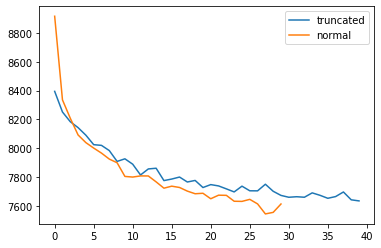

In [67]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(loss_log, label='truncated')
plt.plot(loss_normal, label='normal')
plt.legend()

In [64]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    return top_i[0].item()

def accuracy(testX, testY):
    sum_ok = 0
# Go through a bunch of examples and record which are correctly guessed
    for i in range(testX.shape[0]):
        category = testY[i]
        line = testX[i].reshape(-1)
        category_tensor = torch.tensor([testY[i]], dtype=torch.long)
        line_tensor = testX[i].reshape(testX[i].shape[0],1,testX[i].shape[1])

        output = model(line_tensor)
        guess = categoryFromOutput(output)
        if guess == category :
            sum_ok += 1
            
    acc = sum_ok/testX.shape[0]
    print('acc:', acc)
    return acc

accuracy(Xt, y)

acc: 0.6592222222222223


0.6592222222222223

In [46]:
accuracy(Xt, y)

acc: 0.6461111111111111


0.6461111111111111

In [65]:
X_test_tens = to_tensor(X_test).float().permute(1,2,0)
accuracy(X_test_tens, y_test)

acc: 0.637


0.637

In [57]:
loss_normal = loss_log